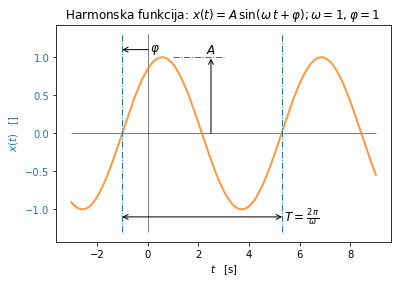

In [1]:
import numpy as np
import matplotlib.pyplot as plt


T = 6
A = 1
t, dt = np.linspace(-0.5*T,1.5*T,201, retstep=True)
ω = 1
ϕ = 1

fig, ax1 = plt.subplots()
plt.title(f'Harmonska funkcija: $x(t) = A\,\sin(\\omega\,t+\\varphi); \\omega={ω}, \\varphi={ϕ}$ ')

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[]', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.vlines(0, -1.3, 1.3, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, A*np.sin(ω*t+ϕ), label='Harmonski podatki', c='C1', lw=2, alpha=0.8) 
ax1.vlines(-ϕ+2*np.pi*np.arange(T/(ω*2*np.pi)+1), -1.3, 1.3, ls='-.', lw=1)
ax1.annotate('$\\varphi$',
            xy=(-ϕ, 1.1), xycoords='data',
            va='center', size='large',
            xytext=(0.1, 1.1), textcoords='data',
            arrowprops=dict(arrowstyle='->',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.hlines(A, 1., 3, ls='-.', lw=1)
ax1.annotate('$A$',
            xy=(2.5, 0), xycoords='data',
            ha='center', size='large',
            xytext=(2.5, A+.05), textcoords='data',
            arrowprops=dict(arrowstyle='<-',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.annotate('$T=\\frac{2\,\pi}{\\omega}$',
            xy=(-ϕ, -1.1), xycoords='data',
            va='center', size='large', 
            xytext=(2*np.pi-ϕ+0.1, -1.1), textcoords='data',
            arrowprops=dict(arrowstyle='<->',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
plt.show()

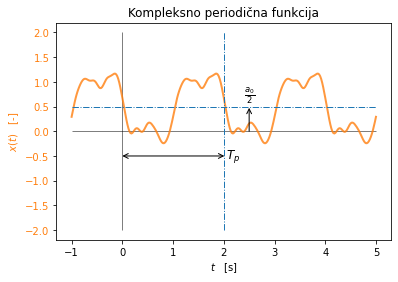

In [5]:
import numpy as np
import matplotlib.pyplot as plt


Tp = 2
t, dt = np.linspace(-0.5*Tp,2.5*Tp,301, retstep=True)
a0 = 1.
N = 10
seed = 0
rg = np.random.default_rng(seed)
a = rg.normal(size=N)*1/np.arange(1,N+1)**2 #skaliranje na koncu, da imajo višje komponente imajo manjšo amplitudo
b = rg.normal(size=N)*1/np.arange(1,N+1)**2
x = a0/2
for n in range(N):
    x += a[n]*np.cos(2*np.pi*(n+1)*t/Tp) + b[n]*np.sin(2*np.pi*(n+1)*t/Tp)

fig, ax1 = plt.subplots()
plt.title(f'Kompleksno periodična funkcija')

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax1.vlines(0, -2, 2, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, x, label='Periodični podatki', c='C1', lw=2, alpha=0.8) 
ax1.vlines([Tp], -2, 2, ls='-.', lw=1)
ax1.hlines(a0/2, np.min(t), np.max(t), ls='-.', lw=1)
ax1.annotate('$\\frac{a_0}{2}$',
            xy=(2.5, 0), xycoords='data',
            ha='center', size='large',
            xytext=(2.5, a0/2+.15), textcoords='data',
            arrowprops=dict(arrowstyle='<-',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.annotate('$T_{p}$',
            xy=(0, -0.5), xycoords='data',
            va='center', size='large', 
            xytext=(Tp+0.05, -0.5), textcoords='data',
            arrowprops=dict(arrowstyle='<->',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
#plt.ylim(-1,2)
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt


Tp = 2
t, dt = np.linspace(-0.5*Tp,2.5*Tp,301, retstep=True)
a0 = 1.
N = 10
seed = 0
rg = np.random.default_rng(seed)
a = rg.normal(size=N)*1/np.arange(1,N+1)**2 #skaliranje na koncu, da imajo višje komponente imajo manjšo amplitudo
b = rg.normal(size=N)*1/np.arange(1,N+1)**2

In [8]:
a

array([ 0.12573022, -0.03302622,  0.07115807,  0.00655626, -0.02142677,
        0.01004431,  0.02661225,  0.01479814, -0.00868809, -0.01265421])

In [9]:
b

array([-0.62327446,  0.01033149, -0.25833675, -0.01367448, -0.04983644,
       -0.02034076, -0.01110733, -0.00494219,  0.00508186,  0.01042513])

In [10]:
c = np.zeros(2*N+1, dtype='complex')
c[N+1:] = 0.5*a-0.5j*b
c[N] = a0/2
c[:N] = np.conj(c[N+1:])[::-1]

In [11]:
c

array([-0.00632711+0.00521257j, -0.00434404+0.00254093j,
        0.00739907-0.00247109j,  0.01330612-0.00555366j,
        0.00502215-0.01017038j, -0.01071339-0.02491822j,
        0.00327813-0.00683724j,  0.03557904-0.12916838j,
       -0.01651311+0.00516575j,  0.06286511-0.31163723j,
        0.5       +0.j        ,  0.06286511+0.31163723j,
       -0.01651311-0.00516575j,  0.03557904+0.12916838j,
        0.00327813+0.00683724j, -0.01071339+0.02491822j,
        0.00502215+0.01017038j,  0.01330612+0.00555366j,
        0.00739907+0.00247109j, -0.00434404-0.00254093j,
       -0.00632711-0.00521257j])

In [21]:
x1 = a0/2
for n in range(N):
    x1 += a[n]*np.cos(2*np.pi*(n+1)*t/Tp) + b[n]*np.sin(2*np.pi*(n+1)*t/Tp)

x = np.zeros(len(t), 'complex')
for n in range(-N,N+1):
    x += c[N+n]*np.exp(2j*np.pi*n*t/Tp)

In [22]:
x1[:10]

array([0.2923326 , 0.39301093, 0.49253799, 0.5867607 , 0.67258178,
       0.74853348, 0.81478531, 0.87257884, 0.92332026, 0.96771094])

In [24]:
x = np.real(x)
x[:10]

array([0.2923326 , 0.39301093, 0.49253799, 0.5867607 , 0.67258178,
       0.74853348, 0.81478531, 0.87257884, 0.92332026, 0.96771094])

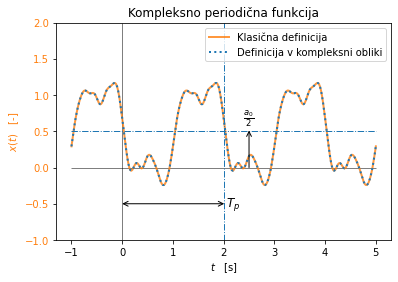

In [25]:
fig, ax1 = plt.subplots()
plt.title(f'Kompleksno periodična funkcija')

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax1.vlines(0, -2, 2, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, x1, label='Klasična definicija', c='C1', lw=2, alpha=0.8) 
ax1.plot(t, x, label='Definicija v kompleksni obliki', c='C0', ls=':', lw=2, alpha=1) 
ax1.vlines([Tp], -2, 2, ls='-.', lw=1)
ax1.hlines(a0/2, np.min(t), np.max(t), ls='-.', lw=1)
ax1.annotate('$\\frac{a_0}{2}$',
            xy=(2.5, 0), xycoords='data',
            ha='center', size='large',
            xytext=(2.5, a0/2+.13), textcoords='data',
            arrowprops=dict(arrowstyle='<-',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.annotate('$T_{p}$',
            xy=(0, -0.5), xycoords='data',
            va='center', size='large', 
            xytext=(Tp+0.05, -0.5), textcoords='data',
            arrowprops=dict(arrowstyle='<->',
                            connectionstyle='arc3,rad=0',
                            color="k", shrinkA=0, shrinkB=0),
            )
ax1.legend(loc=1)
plt.ylim(-1,2)
plt.show()

In [19]:
t, dt = np.linspace(-0.5*Tp,2.5*Tp,300, retstep=True)
t[40:60]

array([-0.19732441, -0.17725753, -0.15719064, -0.13712375, -0.11705686,
       -0.09698997, -0.07692308, -0.05685619, -0.0367893 , -0.01672241,
        0.00334448,  0.02341137,  0.04347826,  0.06354515,  0.08361204,
        0.10367893,  0.12374582,  0.14381271,  0.1638796 ,  0.18394649])

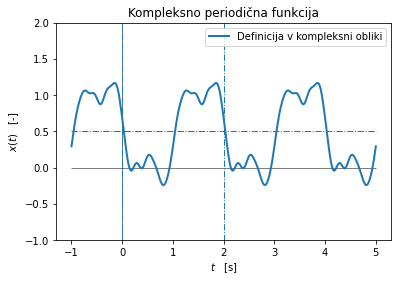

In [24]:
import numpy as np
import matplotlib.pyplot as plt


Tp = 2
t, dt = np.linspace(-0.5*Tp,2.5*Tp,300, retstep=True)
a0 = 1.
N = 10
seed = 0
rg = np.random.default_rng(seed)
a = rg.normal(size=N)*1/np.arange(1,N+1)**2 #skaliranje na koncu, da imajo višje komponente imajo manjšo amplitudo
b = rg.normal(size=N)*1/np.arange(1,N+1)**2

c = np.zeros(2*N+1, dtype='complex')
c[N+1:] = 0.5*a-0.5j*b
c[N] = a0/2
c[:N] = np.conj(c[N+1:])[::-1]

x = np.zeros(len(t), 'complex')
for n in range(-N,N+1):
    x += c[N+n]*np.exp(2j*np.pi*n*t/Tp)
x = np.real(x) # teoretično pričakujemo samo realno rezultat (imaginarni del mora biti na nivoju numerične napake)
    

fig, ax1 = plt.subplots()
plt.title(f'Kompleksno periodična funkcija')

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]')
ax1.tick_params(axis='y')
ax1.vlines(0, -2, 2, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, x, label='Definicija v kompleksni obliki', c='C0', lw=2, alpha=1) 
ax1.vlines([0, Tp], -2, 2, ls='-.', lw=1)
ax1.hlines(a0/2, np.min(t), np.max(t), ls='-.', lw=1)
ax1.legend(loc=1)
plt.ylim(-1,2)
plt.show()

In [25]:
c[11]

(0.06286511054669665+0.3116372312686761j)

In [26]:
n=1
sel = np.logical_and(t>=0, t<=Tp)
np.trapz(x[sel]*np.exp(-2j*np.pi*n*t[sel]/Tp),dx=dt)/Tp

(0.05820334790703212+0.3115787113312921j)

In [ ]:
n=1 # poskusite še druge vrednosti, tudi n>N!
sel = np.logical_and(t>=0, t<=Tp)
np.trapz(x[sel]*np.exp(-2j*np.pi*n*t[sel]/Tp), dx=dt)/Tp

In [29]:
import numpy as np
import matplotlib.pyplot as plt


Tp = 2
t, dt = np.linspace(-0.5*Tp,2.5*Tp,301, retstep=True)
a0 = 1.
N = 10
seed = 0
rg = np.random.default_rng(seed)
a = rg.normal(size=N)*1/np.arange(1,N+1)**2 #skaliranje na koncu, da imajo višje komponente imajo manjšo amplitudo
b = rg.normal(size=N)*1/np.arange(1,N+1)**2

c = np.zeros(2*N+1, dtype='complex')
c[N+1:] = 0.5*a-0.5j*b
c[N] = a0/2
c[:N] = np.conj(c[N+1:])[::-1]

x = np.zeros(len(t), 'complex')
for n in range(-N,N+1):
    x += c[N+n]*np.exp(2j*np.pi*n*t/Tp)
x = np.real(x) # teoretično pričakujemo samo realno rezultat (imaginarni del mora biti na nivoju numerične napake)

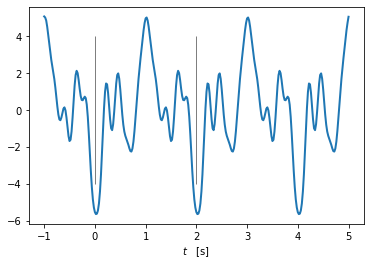

In [43]:
x_d_t = np.gradient(x,dt,edge_order=2)
fig, ax1 = plt.subplots()
ax1.set_xlabel('$t\\quad $[s]')
ax1.vlines([0, Tp], -4, 4, 'k', lw=0.5)
ax1.plot(t, x_d_t, label='$\dot{x}(t)$ - izračunano v času', c='C0', lw=2, alpha=1);

In [44]:
x_d_v = np.zeros(len(t), 'complex') # ODVOD Z VRSTAMI
for n in range(-N,N+1):
    x_d_v += c[N+n]*np.exp(2j*np.pi*n*t/Tp)*2j*np.pi*n/Tp
x_d_v = np.real(x_d_v) # teoretično pričakujemo samo realno rezultat (imaginarni del mora biti na nivoju numerične napake)

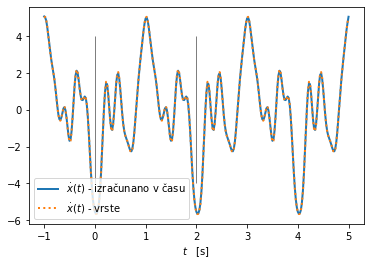

In [45]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('$t\\quad $[s]')
ax1.vlines([0, Tp], -4, 4, 'k', lw=0.5)
ax1.plot(t, x_d_t, label='$\dot{x}(t)$ - izračunano v času', c='C0', lw=2, alpha=1) 
ax1.plot(t, x_d_v, label='$\dot{x}(t)$ - vrste', ls=':', c='C1', lw=2, alpha=1) 
ax1.legend()
plt.show()

In [46]:
x_d_t[:5]

array([5.06269876, 5.00513474, 4.84374415, 4.50109466, 4.04431945])

In [47]:
x_d_v[:5]

array([4.98921293, 5.04199118, 4.87530417, 4.52064805, 4.04922088])

In [39]:
np.testing.assert_allclose(,x_d_v)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 301 / 301 (100%)
Max absolute difference: 0.11284458
Max relative difference: 2.96958027
 x: array([ 5.033917,  5.005135,  4.843744,  4.501095,  4.044319,  3.555088,
        3.101134,  2.713374,  2.378303,  2.049291,  1.672627,  1.217725,
        0.69865 ,  0.176955, -0.256925, -0.517738, -0.562095, -0.412803,...
 y: array([ 4.989213,  5.041991,  4.875304,  4.520648,  4.049221,  3.547862,
        3.088472,  2.703371,  2.377022,  2.058072,  1.6873  ,  1.230172,
        0.700173,  0.162169, -0.28726 , -0.556203, -0.596807, -0.431645,...

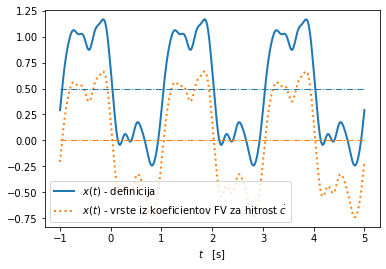

In [48]:
#x_d_t je hitrost, a_0 pa statična komponenta prenešena iz primera zgoraj

N = 10 # identifikacija Fourierovih koeficientov hitrosti
c_d = np.zeros(2*N+1, dtype='complex')
n = np.arange(-N,N+1)
sel = np.logical_and(t>=0, t<=Tp)
for i in n:
    c_d[i+N] = np.trapz(x_d_t[sel]*np.exp(-2j*np.pi*i*t[sel]/Tp), dx=dt)/Tp

x_v = np.zeros(len(t), 'complex') # INTEGRAL Z VRSTAMI
for n in range(-N,N+1):
    if n!=0:
        x_v += c_d[N+n]*np.exp(2j*np.pi*n*t/Tp)/(2j*np.pi*n/Tp)
x_v = np.real(x_v) # teoretično pričakujemo samo realno rezultat (imaginarni del mora biti na nivoju numerične napake)


fig, ax1 = plt.subplots()

ax1.set_xlabel('$t\\quad $[s]')
ax1.plot(t, x, label='$x(t)$ - definicija', c='C0', lw=2, alpha=1) 
ax1.plot(t, x_v, label='$x(t)$ - vrste iz koeficientov FV za hitrost $\dot{c}$', ls=':', c='C1', lw=2, alpha=1) 
ax1.hlines(a0/2, np.min(t), np.max(t), ls='-.', lw=1)
ax1.hlines(0, np.min(t), np.max(t), ls='-.', color='C1', lw=1)
ax1.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


Tp = 2
t, dt = np.linspace(-0.5*Tp,2.5*Tp,301, retstep=True)
x = t%Tp

fig, ax1 = plt.subplots()

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax1.vlines(0, -0.5, 2.5, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, x, label='Periodični podatki', c='C0', lw=2, alpha=1) 
ax1.legend(loc=1)
plt.ylim(-0.5,2.5)
plt.show()

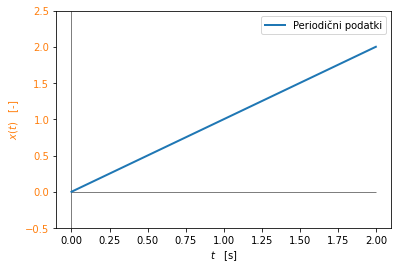

In [67]:
import numpy as np
import matplotlib.pyplot as plt


Tp = 2
t, dt = np.linspace(0,Tp,10001, retstep=True)
x = t

fig, ax1 = plt.subplots()

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax1.vlines(0, -0.5, 2.5, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, x, label='Periodični podatki', c='C0', lw=2, alpha=1) 
ax1.legend(loc=1)
plt.ylim(-0.5,2.5)
plt.show()

In [73]:
N = 50
c = np.zeros(2*N+1, dtype='complex')
n = np.arange(-N,N+1)
for i in n:
    c[i+N] = np.trapz(x*np.exp(-2j*np.pi*i*t/Tp), dx=dt)/Tp
c;

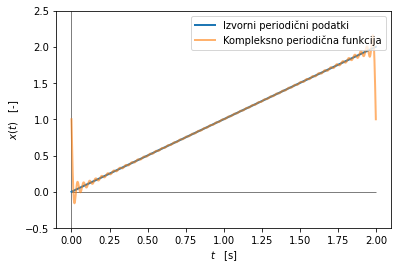

In [74]:
x_r = np.zeros(len(t), 'complex')
for n in range(-N,N+1):
    x_r += c[N+n]*np.exp(2j*np.pi*n*t/Tp)
x_r = np.real(x_r) # teoretično pričakujemo samo realno rezultat (imaginarni del mora biti na nivoju numerične napake)
fig, ax1 = plt.subplots()
ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]')
ax1.vlines(0, -0.5, 2.5, 'k', lw=0.5)
ax1.hlines(0, np.min(t), np.max(t), 'k', lw=0.5)
ax1.plot(t, x, label='Izvorni periodični podatki', c='C0', lw=2, alpha=1) 
ax1.plot(t, x_r, label='Kompleksno periodična funkcija', c='C1', lw=2, alpha=.6) 
ax1.legend(loc=1)
plt.ylim(-0.5,2.5)
plt.show()

In [75]:
import sympy as sym
sym.init_printing()

t, T_p = sym.symbols('t, T_p', real=True)
x_r = sym.fourier_series(t, limits=(t, 0, T_p))

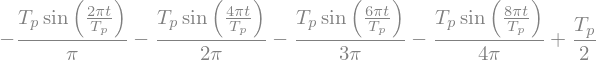

In [79]:
x_r.truncate(5)

In [80]:
n = 1
c_n = sym.integrate(t*sym.exp(-sym.I*2*n*sym.pi*t/T_p), (t, 0, T_p)).simplify()/T_p
c_n

Diracova delta funkcija

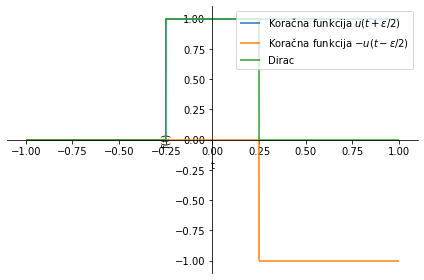

In [85]:
import sympy as sym
t, ε = sym.symbols(r't, \varepsilon')
unit_step = sym.Heaviside(t+ε/2)
p1 = sym.plot(unit_step.subs(ε, +0.5), (t,-1,1), line_color='C0', line_style=':', 
              show=False, label='Koračna funkcija $u(t+\\varepsilon/2)$') 
p2 = sym.plot(-unit_step.subs(ε, -0.5), (t,-1,1), line_color='C1', 
              show=False, label='Koračna funkcija $-u(t-\\varepsilon/2)$') 
p3 = sym.plot(unit_step.subs(ε, +0.5)-unit_step.subs(ε, -0.5), (t,-1,1), line_color='C2', 
              show=False, label='Dirac') 
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()

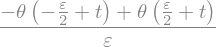

In [90]:
import sympy as sym
t, ε = sym.symbols(r't, \varepsilon')
podatki = {ε: 0.1}
unit_step = sym.Heaviside(t+ε/2) # tukaj moramo pravilno normirati (H0), glej help!
δ_ε = 1/ε * (unit_step-unit_step.subs(ε, -ε))
δ_ε

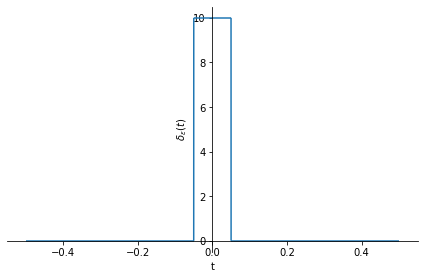

In [91]:
p1 = sym.plot(δ_ε.subs(podatki), (t,-.5,.5), line_color='C0', line_style=':', 
              ylabel='$\\delta_{\\varepsilon}(t)$')

In [92]:
sym.integrate(δ_ε.subs(podatki), (t, -sym.oo, sym.oo))

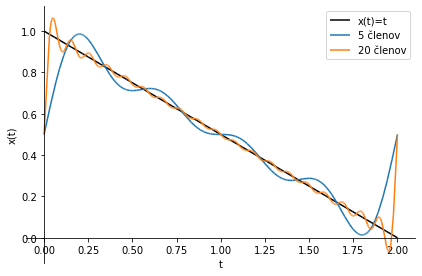

In [93]:
import sympy as sym
sym.init_printing()

t, T_p = sym.symbols('t, T_p')
podatki = {T_p: 2}
x = 1-t/T_p
x_r = sym.fourier_series(x, limits=(t, 0, T_p))

p0 = sym.plot((x).subs(podatki), (t, 0 ,2), label='x(t)=t', show=False, line_color='k', ylabel='x(t)', legend=True)
p1 = sym.plot(x_r.truncate(5).subs(podatki), (t, 0 ,2), line_color='C0', label='5 členov',  show=False)
p2 = sym.plot(x_r.truncate(20).subs(podatki), (t, 0 ,2), line_color='C1', label='20 členov', show=False)
p0.append(p1[0])
p0.append(p2[0])
p0.show()

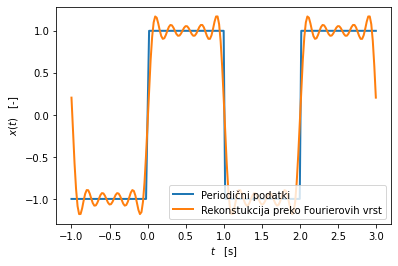

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# signal
T_p = 2
n = 200
x = np.ones(n)
x[:n//4] = -1.
x[n//4:2*n//4] = 1.
x[2*n//4:3*n//4] = -1.
x[3*n//4:n] = 1.

t = np.arange(n)*2*T_p/(n-1) - T_p/2
dt = t[1]-t[0]

# zakaj je ta koda napačna?
t, dt = np.linspace(-0.5*Tp,1.5*Tp,201, retstep=True)
x = np.sign(np.sin(2*np.pi*t/Tp))

# Fourierove vrste
N = 10
c = np.zeros(2*N+1, dtype='complex')
n = np.arange(-N,N+1)
#omejiti se moramo samo na eno periodo, sicer koeficienti niso pravilno izračunani
sel = np.logical_and(t>=0,t<=T_p) 
for i in n:
    c[i+N] = np.trapz(x[sel]*np.exp(-2j*np.pi*i*t[sel]/T_p), dx=dt)/T_p

# rekonstrukcija
x_r = np.zeros(len(t), 'complex')
for _ in range(-N,N+1):
    x_r += c[N+_]*np.exp(2j*np.pi*_*t/T_p)
x_r = np.real(x_r) 

fig, ax1 = plt.subplots()

ax1.set_xlabel('$t\\quad $[s]')
ax1.set_ylabel('$x(t)\quad$[-]')
ax1.tick_params(axis='y')
ax1.plot(t, x, label='Periodični podatki', c='C0', lw=2, alpha=1) 
ax1.plot(t, x_r, label='Rekonstukcija preko Fourierovih vrst', c='C1', lw=2, alpha=1) 
ax1.legend(loc=4)
plt.show()

In [100]:
c

array([ 0.005-4.16333634e-17j, -0.015+6.88404515e-02j,
        0.005-7.44196371e-16j, -0.015+8.94748566e-02j,
        0.005+8.23993651e-17j, -0.015+1.26275030e-01j,
        0.005+2.35055031e-16j, -0.015+2.11577900e-01j,
        0.005-2.99239800e-17j, -0.015+6.36410319e-01j,
        0.005+0.00000000e+00j, -0.015-6.36410319e-01j,
        0.005+2.99239800e-17j, -0.015-2.11577900e-01j,
        0.005-2.35055031e-16j, -0.015-1.26275030e-01j,
        0.005-8.23993651e-17j, -0.015-8.94748566e-02j,
        0.005+7.44196371e-16j, -0.015-6.88404515e-02j,
        0.005+4.16333634e-17j])

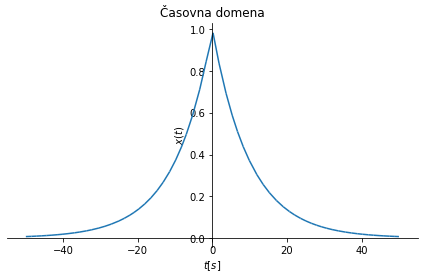

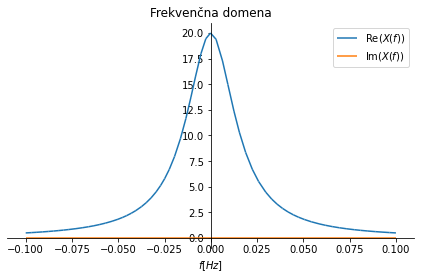

In [5]:
import sympy as sym
t, f = sym.symbols('t, f', real=True)
δ = sym.symbols('\delta', real=True, positive=True)
podatki = {δ: .1}
x = sym.exp(-δ*sym.Abs(t))
X = sym.fourier_transform(x, t, f)

sym.plot(x.subs(podatki), (t,-50,50), xlabel='$t [s]$', ylabel='$x(t)$', title='Časovna domena')
p1 = sym.plot(sym.re(X.subs(podatki)), (f,-.1,.1), xlabel='$f [Hz]$', label='Re$(X(f))$', ylabel='', title='Frekvenčna domena', show=False)
p2 = sym.plot(sym.im(X.subs(podatki)), (f,-.1,.1), line_color='C1', label='Im$(X(f))$', show=False)
p1.extend(p2)
p1.legend = True
p1.show()

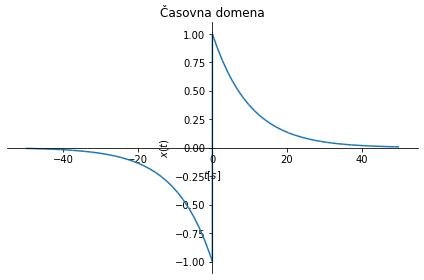

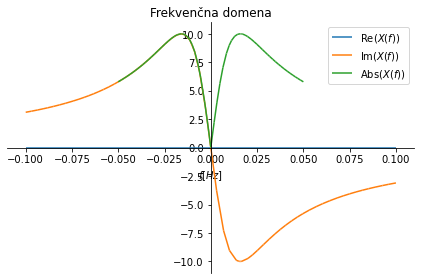

In [8]:
import sympy as sym
t, f = sym.symbols('t, f', real=True)
δ = sym.symbols('\delta', real=True, positive=True)
podatki = {δ: 0.1}
x = sym.sign(t)*sym.exp(-δ*sym.Abs(t))
X = sym.fourier_transform(x, t, f)

sym.plot(x.subs(podatki), (t,-50,50), xlabel='$t [s]$', ylabel='$x(t)$', title='Časovna domena')
p1 = sym.plot(sym.re(X.subs(podatki)), (f,-.1,.1), xlabel='$f [Hz]$', label='Re$(X(f))$', ylabel='', 
              title='Frekvenčna domena', show=False)
p2 = sym.plot(sym.im(X.subs(podatki)), (f,-.1,.1), line_color='C1', label='Im$(X(f))$', show=False)
p3 = sym.plot(sym.Abs(X.subs(podatki)), (f,-.05,.05), line_color='C2', label='Abs$(X(f))$', show=False)
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()

In [14]:
x3 = sym.I*sym.sign(t-2*d)*sym.exp(-δ*sym.Abs(t-2*d))  # kompleksna časovna vrsta; to bo hitro

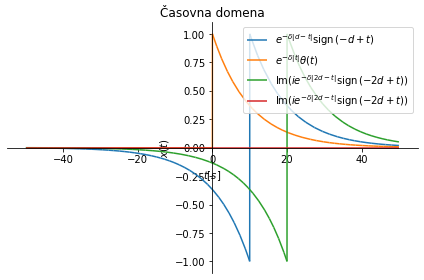

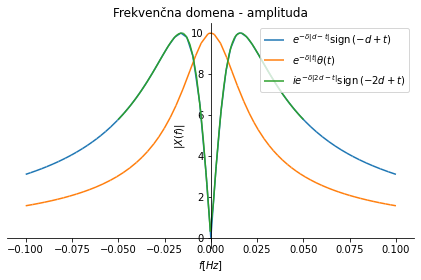

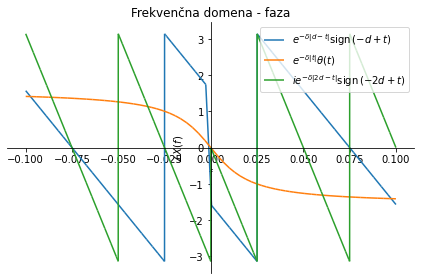

In [17]:
import sympy as sym
t, f, d = sym.symbols('t, f, d', real=True)
δ = sym.symbols('\delta', real=True, positive=True)
podatki = {δ: 0.1, d: 10}
x = sym.sign(t-d)*sym.exp(-δ*sym.Abs(t-d))
x2 = sym.Heaviside(t)*sym.exp(-δ*sym.Abs(t))
x3 = sym.I*sym.sign(t-2*d)*sym.exp(-δ*sym.Abs(t-2*d))  # kompleksna časovna vrsta; to bo hitro
# x = x + sym.I*sym.sign(t)*sym.exp(-δ*sym.Abs(t)) # kompleksna časovna vrsta; to bo trajalo
X = sym.fourier_transform(x, t, f)
X2 = sym.fourier_transform(x2, t, f)
X3 = sym.fourier_transform(x3, t, f)

p1 = sym.plot(x.subs(podatki), (t,-50,50), xlabel='$t [s]$', ylabel='$x(t)$', 
              line_color='C0', title='Časovna domena', show=False, label=f'${sym.latex(x)}$')
p2 = sym.plot(x2.subs(podatki), (t,-50,50), line_color='C1',  label=f'${sym.latex(x2)}$', show=False)
p3 = sym.plot(sym.im(x3).subs(podatki), (t,-50,50), line_color='C2', label=f'Im(${sym.latex(x3)}$)', show=False)
p4 = sym.plot(sym.re(x3).subs(podatki), (t,-50,50), line_color='C3', label=f'Im(${sym.latex(x3)}$)', show=False)
p1.extend(p2)
p1.extend(p3)
p1.extend(p4)
p1.legend = True
p1.show()
p1 = sym.plot(sym.Abs(X.subs(podatki)), (f,-.1,.1), line_color='C0', xlabel='$f [Hz]$', ylabel='$|X(f)|$', 
         title='Frekvenčna domena - amplituda', show=False, label=f'${sym.latex(x)}$')
p2 = sym.plot(sym.Abs(X2.subs(podatki)), (f,-.1,.1), line_color='C1', label=f'${sym.latex(x2)}$', show=False)
p3 = sym.plot(sym.Abs(X3.subs(podatki)), (f,-.05,.05), line_color='C2', label=f'${sym.latex(x3)}$', show=False)
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()
p1 = sym.plot(sym.arg(X.subs(podatki)), (f,-.1,.1), line_color='C0', ylabel='$\\angle X(f)$',
         title='Frekvenčna domena - faza',  show=False, label=f'${sym.latex(x)}$')
p2 = sym.plot(sym.arg(X2.subs(podatki)), (f,-.1,.1), line_color='C1', label=f'${sym.latex(x2)}$', show=False)
p3 = sym.plot(sym.arg(X3.subs(podatki)), (f,-.1,.1), line_color='C2', label=f'${sym.latex(x3)}$', show=False)
p1.extend(p2)
p1.extend(p3)
p1.legend = True
p1.show()